## Import all necessary dependencies

In [ ]:
%pip install simpletransformers
%pip install tensorboardx
%pip install transformers
%pip install sentencepiece
%pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
%pip install nlpaug
%pip install ray


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━

In [ ]:
%pip install ray[tune]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter, defaultdict
from ast import literal_eval
import tensorflow as tf


import torch
import transformers
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel

from transformers import RobertaTokenizer
from transformers import RobertaPreTrainedModel, RobertaModel

import nlpaug.augmenter.word as naw
from sklearn.utils import shuffle
from ray import tune

import pandas as pd
import numpy as np
import os

import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  device = 'cpu'
else:
  device = 'cuda:0'

print(device)

cuda:0


In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
rng_seed = 42
torch.manual_seed(rng_seed)

## Loading the data


In [ ]:
# Connect google drive on colab 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_folder = "dontpatronizeme_v1.4/"

In [ ]:

# Class from 'dont_patronize_me' GitHub RePo

# It is used to manipulate the dont_patronize_me dataset and 
# to merge labels into binary classfications

class DontPatronizeMe:

  def __init__(self, train_path, test_path):

    self.train_path = train_path
    self.test_path = test_path
    self.train_task1_df = None
    self.train_task2_df = None
    self.test_set_df = None

  def load_task1(self):
    """
    Load task 1 training set and convert the tags into binary labels. 
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
    Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    It returns a pandas dataframe with paragraphs and labels.
    """
    rows=[]
    with open(self.train_path) as f: #no joining, just the exact path otherwise, it seems to fail
      for line in f.readlines()[4:]:  

        par_id=line.strip().split('\t')[0]
        art_id = line.strip().split('\t')[1]
        keyword=line.strip().split('\t')[2]
        country=line.strip().split('\t')[3]
        t=line.strip().split('\t')[4]#.lower()
        l=line.strip().split('\t')[-1]
        # if l=='3':
        #   print(t)
        #   print("----------")
        if l=='0' or l=='1':
          lbin=0
        else:
          lbin=1
        rows.append(
          {'par_id':par_id,
          'art_id':art_id,
          'keyword':keyword,
          'country':country,
          'text':t, 
          'label':lbin, 
          'orig_label':l
          }
          )
    df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
    self.train_task1_df = df


In [ ]:
#Get the data ad DontPatronizeMe class

dont_patronize_me= DontPatronizeMe('/content/gdrive/MyDrive/NLP Coursework/dontpatronizeme_pcl.tsv', None) 
dont_patronize_me.load_task1()

open('/content/gdrive/MyDrive/NLP Coursework/dev_semeval_parids-labels.csv')
open('/content/gdrive/MyDrive/NLP Coursework/train_semeval_parids-labels.csv')

training_data_ids = pd.read_csv('/content/gdrive/MyDrive/NLP Coursework/train_semeval_parids-labels.csv')
evaluation_data_ids = pd.read_csv('/content/gdrive/MyDrive/NLP Coursework/dev_semeval_parids-labels.csv')

training_data_ids.par_id = training_data_ids.par_id.astype(str)
evaluation_data_ids.par_id = evaluation_data_ids.par_id.astype(str)

In [ ]:
#Get the data ad DontPatronizeMe class

dont_patronize_me= DontPatronizeMe('data/dontpatronizeme_pcl.tsv', None) 
dont_patronize_me.load_task1()

open('data/dev_semeval_parids-labels.csv')
evaluation_data_ids = pd.read_csv('data/dev_semeval_parids-labels.csv')

open('data/train_semeval_parids-labels.csv')
training_data_ids = pd.read_csv('data/train_semeval_parids-labels.csv')

training_data_ids.par_id = training_data_ids.par_id.astype(str)
evaluation_data_ids.par_id = evaluation_data_ids.par_id.astype(str)

In [ ]:
# Build train set with text and labels

train_rows = [] # will contain label and text
for idx in range(len(training_data_ids)):
    parid = training_data_ids.par_id[idx]
    #print(parid)
    # select row from original dataset to retrieve columns with training information
    text = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].text.values[0]
    label = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].label.values[0]
    train_rows.append({
        'texts':text,
        'labels':label
    })
    train_set_raw = pd.DataFrame(train_rows)

In [ ]:
# Build evaluation set with text and labels
eval_rows = []
for idx in range(len(evaluation_data_ids)):
    parid = evaluation_data_ids.par_id[idx]
    #print(parid)
    # select row from original dataset to retrieve columns with training information
    text = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].text.values[0]
    label = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].label.values[0]
    eval_rows.append({
        #'par_id':parid,
        'texts':text,
        'labels':label,
    })

eval_set = pd.DataFrame(eval_rows)

In [ ]:
# Rebuilt Official train set with keyword and country codes

additional_rows = [] # will contain par_id, label and text
for idx in range(len(training_data_ids)):  
  parid = training_data_ids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve columns with training information
  text = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].text.values[0]
  label = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].label.values[0]
  country = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].country.values[0]
  keyword = dont_patronize_me.train_task1_df.loc[dont_patronize_me.train_task1_df.par_id == parid].keyword.values[0]
  additional_rows.append({
      #'par_id':parid,
      'texts':text,
      'labels':label,
      'country':country,
      'keyword':keyword
  })
  all_cols_train_set = pd.DataFrame(additional_rows)

In [ ]:

# Split train set into train and validation sets
train_set, val_set = train_test_split(train_set_raw, test_size=0.2, random_state=42)

# Save indi

In [ ]:
# Save validation set
val_set.to_csv('/content/gdrive/MyDrive/NLP Coursework/val_set.csv', index=False)


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['love movie', 'movie boring', 'movie great']


In [ ]:
def preproc_text(text):
  # Tokenization
  tokens = word_tokenize(text.lower())
  # Stop words removal
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words] 
  # Punctuation removal
  tokens = [word for word in tokens if word not in string.punctuation]

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return tokens



In [ ]:
train_set_raw

,texts,labels,PreprocText
0,"The scheme saw an estimated 150,000 children f...",1,"scheme saw estimated 150,000 child poor family..."
1,Durban 's homeless communities reconciliation ...,1,durban 's homeless community reconciliation lunch
2,The next immediate problem that cropped up was...,1,next immediate problem cropped assist unfortun...
3,Far more important than the implications for t...,1,far important implication economy god dollar l...
4,To strengthen child-sensitive social protectio...,1,strengthen child-sensitive social protection s...
...,...,...,...
8370,Rescue teams search for survivors on the rubbl...,0,rescue team search survivor rubble building fo...
8371,The launch of ' Happy Birthday ' took place la...,0,launch happy birthday took place last saturday...
8372,"The unrest has left at least 20,000 people dea...",0,"unrest left least 20,000 people dead nigeria m..."
8373,You have to see it from my perspective . I may...,0,see perspective may journalist strictest sense...


In [ ]:
preproc = []

for idx in range(len(train_set_raw)):
  text = train_set_raw.loc[idx, 'texts']
  tokens = preproc_text(text)
  preproc.append(tokens)







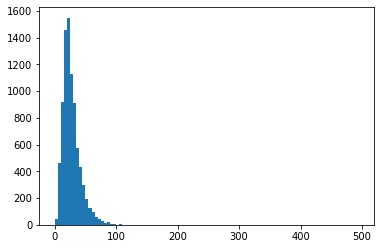

In [ ]:
#Histogram of preproc lengths
plt.hist([len(x) for x in preproc], bins = np.arange(0,500,5))
plt.show()

In [ ]:
padded_preproc=[]
for words in preproc:
  padded_words = words[:128]+['<pad>']*(128 - len(words))
  padded_preproc.append(padded_words)

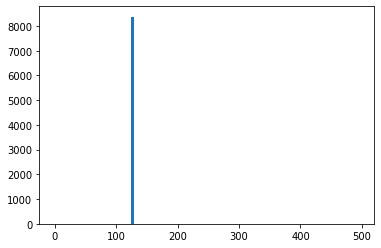

In [ ]:
#Histogram of preproc lengths
plt.hist([len(x) for x in padded_preproc], bins = np.arange(0,500,5))
plt.show()

In [ ]:
# Join tokens back to text
preprocessed_data = [' '.join(text) for text in preproc]

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
train_set_raw['PreprocText'] = preprocessed_data
X = vectorizer.fit(train_set_raw['PreprocText'])

In [ ]:
# Split train set into train and validation sets
train_set, val_set = train_test_split(train_set_raw, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**SIMPLE METHOD I**: Bag of words Naive Bayes (no upsampling)

```
`# This is formatted as code`
```



In [ ]:
# # Create a bag of words

X_train = X.transform(train_set['PreprocText'])
y_train = train_set['labels']
X_test = X.transform(val_set['PreprocText'])
y_test = val_set['labels']


In [ ]:
X_test.shape

(1675, 1000)

In [ ]:
# Train the classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Test the classifier
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8847761194029851


In [ ]:
# Print the confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1423   85]
 [ 108   59]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1508
           1       0.41      0.35      0.38       167

    accuracy                           0.88      1675
   macro avg       0.67      0.65      0.66      1675
weighted avg       0.88      0.88      0.88      1675



**Method II SVM**

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()

In [ ]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
# Print the confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1419   89]
 [ 131   36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1508
           1       0.29      0.22      0.25       167

    accuracy                           0.87      1675
   macro avg       0.60      0.58      0.59      1675
weighted avg       0.85      0.87      0.86      1675



Method III logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
# Print the confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[1469   39]
 [ 139   28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1508
           1       0.42      0.17      0.24       167

    accuracy                           0.89      1675
   macro avg       0.67      0.57      0.59      1675
weighted avg       0.86      0.89      0.87      1675



**Simple Method III**: FeedForward **NN**

In [ ]:
def get_word2idx(tokenized_corpus):
  vocabulary = []
  for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
  
  word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
  # we reserve the 0 index for the padding token
  word2idx['<pad>'] = 0
  
 
  return word2idx

In [ ]:
len(padded_preproc)

8375

In [ ]:
word2idx=get_word2idx(padded_preproc)

In [ ]:
#vectorize sentences
vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in padded_preproc]

In [ ]:
sent_tensor = torch.zeros((len(vectorized_sents), 128)).long()

In [ ]:
for idx, sent in enumerate(vectorized_sents):
  sent_tensor[idx,:] = torch.LongTensor(sent)

In [ ]:
label_tensor = torch.FloatTensor(train_set_raw['labels'])

In [ ]:
import random
num_range = range(len(label_tensor))
random_subset = random.sample(num_range, int(len(label_tensor)*0.2))
complement_subset = np.setdiff1d(num_range, random_subset)

In [ ]:
y_test = label_tensor[random_subset]
y_train = label_tensor[complement_subset]
X_test = sent_tensor[random_subset]
X_train = sent_tensor[complement_subset]

In [ ]:
class FFNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):  
        super(FFNN, self).__init__()
        
        # embedding (lookup layer) layer
        # padding_idx argument makes sure that the 0-th token in the vocabulary
        # is used for padding purposes i.e. its embedding will be a 0-vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # hidden layer
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        
        # activation
        self.relu1 = nn.ReLU()
        
        # hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        # activation

        self.relu2 = nn.ReLU()

        # linear layet

        self.fc3 = nn.Linear(hidden_dim, num_classes)

        # sigmoid

        # self.sigmoid = nn.Sigmoid()



      
    
    def forward(self, x):
        # x has shape (batch_size, max_sent_len)

        embedded = self.embedding(x)
        # `embedded` has shape (batch size, max_sent_len, embedding dim)

        ########################################################################
        # Q: Compute the average embeddings of shape (batch_size, embedding_dim)
        ########################################################################
        # Implement averaging that ignores padding (average using actual sentence lengths).
        # Hint: You need to ignore the <pad> token when averaging.
        # How does this affect the result?
        
        sent_lens = x.ne(0).sum(1, keepdims=True)
        averaged = embedded.sum(1) / sent_lens

        out = self.fc1(averaged)
        out = self.relu1(out)
        # out = self.fc2(out)
        # out = self.relu2(out)
        out = self.fc3(out)
        # out = self.sigmoid(out)
        return out

In [ ]:
import torch.optim as optim


In [ ]:
# Reset the seed before every model construction for reproducible results
# fix_seed()

# we will train for N epochs (The model will see the corpus N times)
EPOCHS = 25

# Learning rate is initially set to 0.5
LRATE = 0.05

# we define our embedding dimension (dimensionality of the output of the first layer)
EMBEDDING_DIM = 300

# dimensionality of the output of the second hidden layer
HIDDEN_DIM = 50

# the output dimension is the number of classes, 1 for binary classification
OUTPUT_DIM = 1

# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx)+1, OUTPUT_DIM)

# Print the model
print(model)

# we use the stochastic gradient descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=LRATE)

# we use the binary cross-entropy loss with sigmoid (applied to logits) 
# Recall that we did not apply any activation to our output layer, hence we need
# to make our outputs look like probabilities.
loss_fn = nn.BCEWithLogitsLoss()

# Input and label tensors
feature = X_train
target = y_train

################
# Start training
################
print(f'Will train for {EPOCHS} epochs')
for epoch in range(1, EPOCHS + 1):
  # to ensure the dropout (explained later) is "turned on" while training
  # good practice to include even if do not use here
  model.train()
  
  # we zero the gradients as they are not removed automatically
  optimizer.zero_grad()
  
  # squeeze is needed as the predictions will have the shape (batch size, 1)
  # and we need to remove the dimension of size 1
  predictions = model(feature).squeeze(1)

  # Compute the loss
  loss = loss_fn(predictions, target)
  train_loss = loss.item()

  # calculate the gradient of each parameter
  loss.backward()

  # update the parameters using the gradients and optimizer algorithm 
  optimizer.step()
  
  print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f}')

FFNN(
  (embedding): Embedding(26450, 300, padding_idx=0)
  (fc1): Linear(in_features=300, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
Will train for 25 epochs
| Epoch: 01 | Train Loss: 0.754
| Epoch: 02 | Train Loss: 0.741
| Epoch: 03 | Train Loss: 0.728
| Epoch: 04 | Train Loss: 0.715
| Epoch: 05 | Train Loss: 0.703
| Epoch: 06 | Train Loss: 0.691
| Epoch: 07 | Train Loss: 0.680
| Epoch: 08 | Train Loss: 0.669
| Epoch: 09 | Train Loss: 0.659
| Epoch: 10 | Train Loss: 0.648
| Epoch: 11 | Train Loss: 0.639
| Epoch: 12 | Train Loss: 0.629
| Epoch: 13 | Train Loss: 0.620
| Epoch: 14 | Train Loss: 0.611
| Epoch: 15 | Train Loss: 0.602
| Epoch: 16 | Train Loss: 0.593
| Epoch: 17 | Train Loss: 0.585
| Epoch: 18 | Train Loss: 0.577
| Epoch: 19 | Train Loss: 0.569
| Epoch: 20 | Train Loss: 0.562
| Epoch: 21 | Train Loss: 0.555
| Epoch: 22 | Train Loss: 0

In [ ]:
with torch.no_grad():
  y_pred = model(X_test)
  y_pred = torch.round(torch.sigmoid(y_pred))

# Print the confusion matrix and classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1514    0]
 [ 161    0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      1514
         1.0       0.00      0.00      0.00       161

    accuracy                           0.90      1675
   macro avg       0.45      0.50      0.47      1675
weighted avg       0.82      0.90      0.86      1675



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Construct the model
model = FFNN(EMBEDDING_DIM, HIDDEN_DIM, len(word2idx), OUTPUT_DIM)

In [ ]:
len(word2idx)

26449

In [ ]:
model

FFNN(
  (embedding): Embedding(26449, 50, padding_idx=0)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
embedding = nn.Embedding(len(word2idx), 50)
fc1 = nn.Linear(50, 50)
  # activation
relu1 = nn.ReLU()
        
        # output layer
fc2 = nn.Linear(50, 1) 


sent_lens = X_train[0:16].ne(0).sum(1, keepdims=True)


In [ ]:
embedded = embedding(X_train[0:16])
averaged = embedded.sum(1) / sent_lens

fc2(relu1(fc1(averaged))).squeeze(1).shape

torch.Size([16])

In [ ]:
model(X_train[0:16]).squeeze(1)

tensor([-0.0770, -0.1844, -0.1349, -0.0270, -0.1329, -0.0369, -0.0863, -0.1032,
        -0.1133, -0.2335, -0.1391, -0.1201, -0.2389, -0.2016, -0.1156, -0.1312],
       grad_fn=<SqueezeBackward1>)

In [ ]:
[len(x) for x in X_train]

[128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128,
 128

## Data augmentation

### Downsampling of the majority class

In [ ]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 61.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

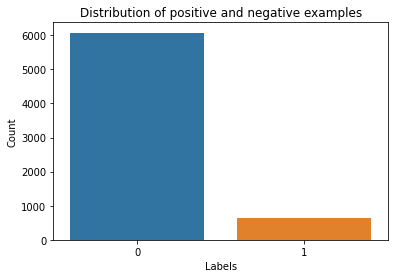

Text(0.5, 1.0, 'Distribution of positive and negative examples after downsampling of negative examples')

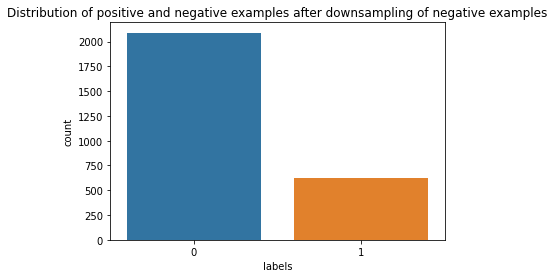

In [ ]:
# Use downsampling of negative examples to balance the dataset
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html

# Split train set into positive and negative examples
#positive = train_set[train_set['labels'] == 1]
#negative = train_set[train_set['labels'] == 0]

# Plot distribution of positive and negative examples
fig, ax = plt.subplots()
sns.countplot(x='labels', data=train_set, ax=ax)
ax.set_title('Distribution of positive and negative examples')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
plt.show()

# Downsample negative examples
rus = RandomUnderSampler(sampling_strategy = 0.3, random_state=42)
X_res, y_res = rus.fit_resample(train_set[['texts']], train_set[['labels']])
train_set_balanced = pd.concat([X_res, y_res], axis=1)

# Plot distribution of positive and negative examples
fig, ax = plt.subplots()
sns.countplot(x='labels', data=train_set_balanced, ax=ax)   
ax.set_title('Distribution of positive and negative examples after downsampling of negative examples')



### Augmentation via contextual word embeddings

In [ ]:
# Taken from https://neptune.ai/blog/data-augmentation-nlp



In [ ]:
# Create a function for randomly apply contextual word embedding augmentation to a sleected number of both positive and negative examples 

def random_augment(dataframe, num_positive, num_negative, aug_p):

    aug = naw.ContextualWordEmbsAug(
        model_path='bert-base-uncased', action="substitute", aug_p=aug_p)


    augmented_positive = []
    augmented_negative = []


    negative_examples = dataframe[dataframe['labels'] == 0]['texts'].sample(num_negative, random_state=42)
    positive_examples = dataframe[dataframe['labels'] == 1]['texts'].sample(num_positive, random_state=42)

    for text_pos, text_neg in tqdm(zip(negative_examples, positive_examples)):
        augmented_negative.append(aug.augment(text_neg))
        augmented_positive.append(aug.augment(text_pos))

    # Add augmented examples to the train set
    new_negative = pd.DataFrame({'texts':augmented_negative, 'labels':0})
    new_positive = pd.DataFrame({'texts':augmented_positive, 'labels':1})
    new_data_frame = shuffle(pd.concat([dataframe, new_negative, new_positive], axis=0))

    return new_data_frame









In [ ]:
aug_p = 0.3
num_positive = 200
num_negative = 200

train_set_augmented_balanced = random_augment(train_set_balanced, num_positive, num_negative, aug_p)


0it [00:00, ?it/s]

In [ ]:
# Save augmented dataset to a csv
train_set_augmented_balanced.to_csv(f'data/augmentations_{num_positive}_.csv') 

NameError: name 'num_positive' is not defined

## Creating custom DataSet Class for PyTorch

In [ ]:
train_set_augmented_balanced = pd.read_csv('data/augmentations_200_.csv')

In [ ]:
val_set = pd.read_csv('data/val_set.csv')

In [ ]:
train_set_augmented_balanced

,Unnamed: 0,texts,labels
0,2166,"""The establishment of a library is an ideal be...",1
1,1710,Loach is very engaged in everyday struggles of...,0
2,1750,The Island ( theislandyork.org ) provides youn...,0
3,1666,""""""" New thinking , new paradigms , new policie...",0
4,1485,England rout Windies in just three days in day...,0
...,...,...,...
3112,163,"['in their imposing brick building, now few bl...",0
3113,1911,To prevent minors and vulnerable persons from ...,0
3114,1474,More than 200 people are resettled in Launcest...,0
3115,1954,THE Penang Island City Council ( MBPP ) took a...,0


In [ ]:
# LONGFORMER

# Create a function to tokenize the text and return the input ids, attention mask and labels as PyTorch tensors

import torch
from torch.utils.data import Dataset
from transformers import LongformerTokenizer

class TextClassificationDataset(Dataset):
    def __init__(self, data_frame, tokenizer, max_seq_length):
        self.data = data_frame
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['texts']
        label = self.data.iloc[idx]['labels']
        
        # Tokenize text using LongformerTokenizer
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Return inputs and label as PyTorch tensors
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Example usage:
# Load the pandas DataFrame containing text samples and labels
train_set_augmented_balanced = pd.read_csv('data/augmentations_200_.csv')

# Initialize LongformerTokenizer and set max sequence length
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
max_seq_length = 512

# Create TextClassificationDataset instance
train_dataset_long = TextClassificationDataset(train_set_augmented_balanced, tokenizer, max_seq_length)
val_dataset_long = TextClassificationDataset(val_set, tokenizer, max_seq_length)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
import torch
import torch.nn as nn
from transformers import LongformerModel

class LongformerForTextClassification(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        
        # Load the pretrained Longformer model
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Add a classification head on top of Longformer
        self.classifier = nn.Linear(self.longformer.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask):
        # Pass inputs through Longformer
        outputs = self.longformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        # Use the last hidden state as input to the classification head
        last_hidden_state = outputs.last_hidden_state
        logits = self.classifier(last_hidden_state[:, 0, :])
        
        # Return logits
        return logits

In [ ]:

# Example usage:
# Define training parameters
# batch_size = 16
# num_epochs = 10
# learning_rate = 2e-5

# Initialize model, optimizer and loss function
# model = LongformerForTextClassification(num_labels=2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# loss_fn = nn.CrossEntropyLoss()

# Create PyTorch DataLoader instance
# dataloader = torch.utils.data.DataLoader(train_dataset_long, batch_size=batch_size, shuffle=True)

# Train the model
#for epoch in range(num_epochs):
    # for batch in tqdm(dataloader):
        # input_ids = batch['input_ids']
        # attention_mask = batch['attention_mask']
        # labels = batch['label']
        
        # Zero the gradients
        # optimizer.zero_grad()
        
        # Forward pass
        # logits = model(input_ids, attention_mask)
        # loss = loss_fn(logits, labels)
        
        # Backward pass
        # loss.backward()
        # optimizer.step()
# In this example, we define some training parameters such as the batch size, number of epochs, and learning rate. We initialize the model, optimizer, and loss function, and create a PyTorch DataLoader instance from the dataset. We then iterate over the dataset using a for loop, compute the forward and backward passes, and update the model parameters using the optimizer.






loading configuration file https://huggingface.co/allenai/longformer-base-4096/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0690955d8f70934f95adf0fb108d5f7322d02f8d7dd938b7b133cb7421e120e6.b25f41ff6acdcb7ab47c505c70e351b3fc01957b3798197e5ac6e8efc547ac99
Model config LongformerConfig {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": 

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class TextClassifierTrainer:
    def __init__(self, model, train_dataset, val_dataset, batch_size, lr):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.lr = lr
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []
        
    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss = 0.0
            self.model.train()
            for batch in self.train_dataloader:
                self.optimizer.zero_grad()
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask)
                loss = self.loss_fn(outputs.logits, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * input_ids.size(0)
            
            train_loss = train_loss / len(self.train_dataset)
            self.train_losses.append(train_loss)
            
            val_loss, val_acc = self.evaluate()
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)
            
            print(f'Epoch {epoch+1}: Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}')
            
    def evaluate(self):
        val_loss = 0.0
        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for batch in self.val_dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask)
                loss = self.loss_fn(outputs.logits, labels)
                val_loss += loss.item() * input_ids.size(0)
                preds = torch.argmax(outputs.logits, dim=1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)
            
        val_loss = val_loss / len(self.val_dataset)
        val_acc = correct / total
        
        return val_loss, val_acc

In [ ]:

model = LongformerForTextClassification(num_labels=2)
trainer = TextClassifierTrainer(model, train_dataset_long, val_dataset_long, batch_size=32, lr=1e-5)
trainer.train(num_epochs=10)

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA out of memory. Tried to allocate 386.00 MiB (GPU 0; 23.88 GiB total capacity; 22.24 GiB already allocated; 278.50 MiB free; 22.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## WORKING BERT MODEL

In [ ]:
from transformers import BertTokenizer

class TextClassificationDatasetBert(torch.utils.data.Dataset):

    def __init__(self, data_frame, max_len):
        self.data = data_frame
        self.max_len = max_len
        self.texts = data_frame['texts'].values
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.data.iloc[item]['texts']
        label = self.data.iloc[item]['labels']
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
import torch.nn as nn
from transformers import BertModel

class BertClassification(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.linear(pooled_output)
        return logits

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
import tqdm


class BertTrainer:
    def __init__(self, model, train_dataset, val_dataset=None, test_dataset=None, batch_size=32, lr=2e-5, num_epochs=3):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(self.train_dataset)*self.num_epochs)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def train(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False) if self.val_dataset else None
        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False) if self.test_dataset else None
        
        for epoch in range(self.num_epochs):
            self.model.train()
            train_loss, train_acc, train_f1 = 0.0, 0.0, 0.0
            with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
                for i, batch in enumerate(tepoch):
                    self.optimizer.zero_grad()
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['label'].to(self.device)
                    logits = self.model(input_ids, attention_mask)
                    loss = self.loss_fn(logits, labels)
                    loss.backward()
                    nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()
                    self.scheduler.step()
                    train_loss += loss.item()
                    train_acc += (logits.argmax(dim=-1) == labels).sum().item()
                    train_f1 += f1_score(labels.cpu(), logits.cpu().argmax(dim=-1), average='weighted')
                    if i % 20 == 0:
                        tepoch.set_description(f"Epoch {epoch}/{self.num_epochs}")
                        tepoch.set_postfix(Loss = f"{train_loss/(i+1):.4f}", Accuracy = f"{train_acc/((i+1)*self.batch_size):.4f}", F1 = f"{train_f1/(i+1):.4f}")
            train_loss /= len(train_loader)
            train_acc /= len(self.train_dataset)
            train_f1 /= len(train_loader)
            print(f"Epoch: {epoch+1}/{self.num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} Train F1: {train_f1:.4f}")
            
            if val_loader:
                val_loss, val_acc, val_f1 = self.evaluate(val_loader)
                print(f"Epoch: {epoch+1}/{self.num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f} Validation F1: {val_f1:.4f}")
                
        if test_loader:
            test_loss, test_acc, test_f1 = self.evaluate(test_loader)
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")
        
    def evaluate(self, dataloader):
        self.model.eval()
        eval_loss, eval_acc, eval_f1 = 0.0, 0.0, 0.0
        with torch.no_grad():
            with tqdm.tqdm(dataloader, unit="batch") as tepoch:
                for idx, batch in enumerate(tepoch):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    batch['attention_mask'].to(self.device)
                    labels = batch['label'].to(self.device)
                    logits = self.model(input_ids, attention_mask)
                    loss = self.loss_fn(logits, labels)
                    eval_loss += loss.item()
                    eval_acc += (logits.argmax(dim=-1) == labels).sum().item()
                    eval_f1 += f1_score(labels.cpu(), logits.argmax(dim=-1).cpu(), average='weighted')
                    tepoch.set_description(f"Validation")
                    tepoch.set_postfix(Loss = f"{eval_loss/(idx+1):.4f}", Accuracy = f"{eval_acc/((idx+1)*self.batch_size):.4f}", F1 = f"{eval_f1/(idx+1):.4f}")
                eval_loss /= len(dataloader)
                eval_acc /= len(self.val_dataset)
                eval_f1 /= len(dataloader)
                    
            
        return eval_loss, eval_acc, eval_f1

In [ ]:
train_dataset_bert = TextClassificationDatasetBert(train_set_augmented_balanced, max_len=128)
val_dataset_bert = TextClassificationDatasetBert(val_set, max_len=128)

In [ ]:


model = BertClassification(num_classes=2)

# Initialize the trainer
trainer = BertTrainer(model, train_dataset=train_dataset_bert, val_dataset=val_dataset_bert, batch_size=16, lr=2e-5, num_epochs=3)

# Train the model
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Epoch: 1/3, Train Loss: 0.4823, Train Accuracy: 0.7629 Train F1: 0.7224


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.82batch/s, Accuracy=0.8032, F1=0.8148, Loss=0.4421]


Epoch: 1/3, Validation Loss: 0.4421, Validation Accuracy: 0.8184 Validation F1: 0.8148


Epoch 1/3: 100%|██████████| 195/195 [00:48<00:00,  4.05batch/s, Accuracy=0.8650, F1=0.8626, Loss=0.3178]


Epoch: 2/3, Train Loss: 0.3179, Train Accuracy: 0.8653 Train F1: 0.8630


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.08batch/s, Accuracy=0.8472, F1=0.8561, Loss=0.3430]


Epoch: 2/3, Validation Loss: 0.3430, Validation Accuracy: 0.8632 Validation F1: 0.8561


Epoch 2/3: 100%|██████████| 195/195 [00:48<00:00,  4.05batch/s, Accuracy=0.9430, F1=0.9426, Loss=0.1683]


Epoch: 3/3, Train Loss: 0.1705, Train Accuracy: 0.9429 Train F1: 0.9424


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.55batch/s, Accuracy=0.8866, F1=0.9068, Loss=0.2871]

Epoch: 3/3, Validation Loss: 0.2871, Validation Accuracy: 0.9033 Validation F1: 0.9068


### CODE BELOW DOESN'T WORK 

In [ ]:
### END OF THE 

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# Taken from lab 5

from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DPMDataset class to load data into the model
# During each iteration, the model will receive a batch of texts and labels
# method __getitem__ will be called to return a batch of texts and labels
# Then, the ''collate_fn'' function will process the list of samples into their encodings and return a batch when called by the iterator during training



class DPMDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = input_set['texts']
        self.labels = input_set['labels']

    def __getitem__(self, idx):
#if idx < len(self.texts):
          item = {'text': self.texts[idx],
                'label': self.labels[idx]}

          return item

#else:
#return 

    def collate_fn(self, batch):



        texts = []
        labels = []



        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        #The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=300)

        labels_all = {}
        #encodings['text'] = torch.tensor(texts)
        encodings['label'] =  torch.tensor(labels)
        return encodings
    
    def __len__(self):
        return len(self.texts)

   

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217

In [ ]:
# Create train and validation datasets

max_len = 128
train_dataset = DPMDataset(tokenizer, train_set_augmented_balanced)

val_dataset = DPMDataset(tokenizer, val_set)


## Trying Longformer

In [ ]:

import pandas as pd
import datasets
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, Trainer, TrainingArguments, LongformerConfig
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import wandb
import os

In [ ]:
config = LongformerConfig()

config

LongformerConfig {
  "attention_probs_dropout_prob": 0.1,
  "attention_window": 512,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "sep_token_id": 2,
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
API = 'a18126ca7a6f1fe683e47a1e2f0e546590106fb3'

AttributeError: module 'wandb' has no attribute 'API'

In [ ]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## BERT model

In [ ]:
# Define the BERT model for classification

class DPM_BERT(RobertaPreTrainedModel): 
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = BertModel(config)
        self.projection = torch.nn.Sequential(nn.Dropout(0.2), nn.Linear(config.hidden_size, 2))
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        
        outputs = self.roberta(input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask= head_mask, 
            output_attentions = output_attentions, 
            output_hidden_states = output_hidden_states,
            return_dict = return_dict)
        
        logits = self.projection(outputs[1])

        return logits # (loss), logits, (hidden_states), (attentions)
    
    def freeze_bert_encoder(self):
        for param in self.roberta.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.roberta.parameters():
            param.requires_grad = True

# Create the model

        

In [ ]:
# Define a trainer class to train the model

class DPM_Trainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = {}
        labels['label'] = inputs.pop("labels")
        outputs = model(**inputs)

        labels = labels['label']


        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(outputs.view(-1, 2), labels.view(-1))
        loss = loss
        return (loss, outputs) if return_outputs else loss


In [ ]:
def training(train_dataset, val_dataset, num_train_epochs, learning_rate, per_device_train_batch_size, per_device_eval_batch_size):

    model = DPM_BERT.from_pretrained("bert-base-cased")


    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=num_train_epochs,              # total number of training epochs
        per_device_train_batch_size=per_device_train_batch_size, # batch size per device during training
        per_device_eval_batch_size=per_device_eval_batch_size,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=10,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='F1',
        greater_is_better=True,
        learning_rate=learning_rate,
        adam_epsilon=1e-8,
        dataloader_num_workers=4,
        report_to='none', 
        lr_scheduler_type='linear'
    )

    trainer = DPM_Trainer(
        model=model,                         # the instantiated huggingFace Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset 
        eval_dataset=val_dataset,            # evaluation dataset
        data_collator=train_dataset.collate_fn,
                    
    )

    # Train the model
    trainer.train()

    # Save the model
    trainer.save_model()

    # Evaluate the model
    trainer.evaluate()

    return trainer




In [ ]:
# Train the model

training( train_dataset, val_dataset, learning_rate = 2e-5, num_train_epochs=5, per_device_train_batch_size=16, per_device_eval_batch_size=16)


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Model config RobertaConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transform

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.9/dist-packages/transformers/trainer_utils.py", line 696, in __call__
    return self.data_collator(features)
  File "/tmp/ipykernel_425/1427992435.py", line 38, in collate_fn
    texts.append(b['text'])
KeyError: 'text'


In [ ]:
# Create a dataloader for the training set

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    collate_fn=train_dataset.collate_fn
)

# Create a dataloader for the validation set

val_data_loader = DataLoader(
    val_dataset,
    batch_size=16,
    num_workers=4,
    collate_fn=val_dataset.collate_fn
)


In [ ]:
# Define the training loop

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        
        texts = d["texts"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs[0], dim=1)
        loss = loss_fn(outputs[0], targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)


# Define the evaluation loop
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            texts = d["texts"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs[0], dim=1)
            
            loss = loss_fn(outputs[0], targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Import the AdamW optimizer and the learning rate scheduler

from transformers import AdamW, get_linear_schedule_with_warmup


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Run the training loop

# Define the training parameters

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup( optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# Run the training loop

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):
        
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(train_set_augmented_balanced)
        )
        
        print(f'Train loss {train_loss} accuracy {train_acc}')
        
        val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(val_set)
        )
        
        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()
    
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_32/217650699.py", line 36, in __getitem__
    'targets': torch.tensor(target, dtype=torch.long)
ValueError: too many dimensions 'Series'


##DISTIL BERT